<a href="https://colab.research.google.com/github/Bksimon/Emory_MSBA/blob/main/E_commerce_Spending_PredictorHW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements entire CRISP data mining process to model a **Linear Regressor, Knn Regressor, and Decision Tree Regressor** each with different iteratons to predict online customer spending:
*   Mean Squared Error (MSE) chosen as performance metric
*   Feature Engineering - created 3 additional features to capture non-linearities
*   Hyper paramter tuning - used GridSearchCV with nested cross validation

**Linear Regressor** with L1 normalization had best generalization performance on validation data and will be implemented out of the possible 3.

In [ ]:
# python 2/3 compatible codebase
from __future__ import division, print_function, unicode_literals

In [ ]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, neighbors, datasets
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, StratifiedShuffleSplit, validation_curve, StratifiedKFold, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso

from numpy import interp
sc = StandardScaler()
import itertools
import io
import math

# set seed
np.random.seed(42)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HW4_zData.csv to HW4_zData.csv


In [ ]:
### Load Data ###
df = pd.read_csv(io.StringIO(uploaded['HW4_zData.csv'].decode('utf-8')))
df.head()

# attributes/features: source_a to w, freq, . . .
X = df.iloc[:,:24] # cols 0-23

features = []
for col in X.columns:
  features.append(col)

# target variable: customer spending
y = df.iloc[:,24]

       sequence_number           US     source_a     source_c     source_b  \
count      2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean       1000.500000     0.824500     0.126500     0.056000     0.060000   
std         577.494589     0.380489     0.332495     0.229979     0.237546   
min           1.000000     0.000000     0.000000     0.000000     0.000000   
25%         500.750000     1.000000     0.000000     0.000000     0.000000   
50%        1000.500000     1.000000     0.000000     0.000000     0.000000   
75%        1500.250000     1.000000     0.000000     0.000000     0.000000   
max        2000.000000     1.000000     1.000000     1.000000     1.000000   

          source_d     source_e    source_m     source_o     source_h  \
count  2000.000000  2000.000000  2000.00000  2000.000000  2000.000000   
mean      0.041500     0.151000     0.01650     0.033500     0.052500   
std       0.199493     0.358138     0.12742     0.179983     0.223089   
min  

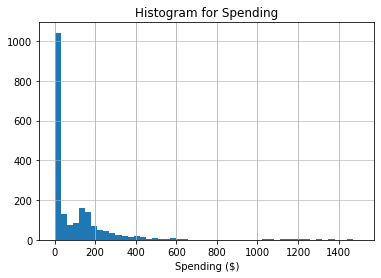

In [ ]:
### Exploratory Data Analysis ###
# min, max, mean, std dev for all features and target
pd.options.display.max_columns = None
print(df.describe())

# Exploring Target Variable
df['Spending'].hist(grid=True, bins=50)
plt.title('Histogram for Spending')
plt.xlabel('Spending ($)')
plt.grid(axis='y', alpha=.75)
plt.show()

Visualizations

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


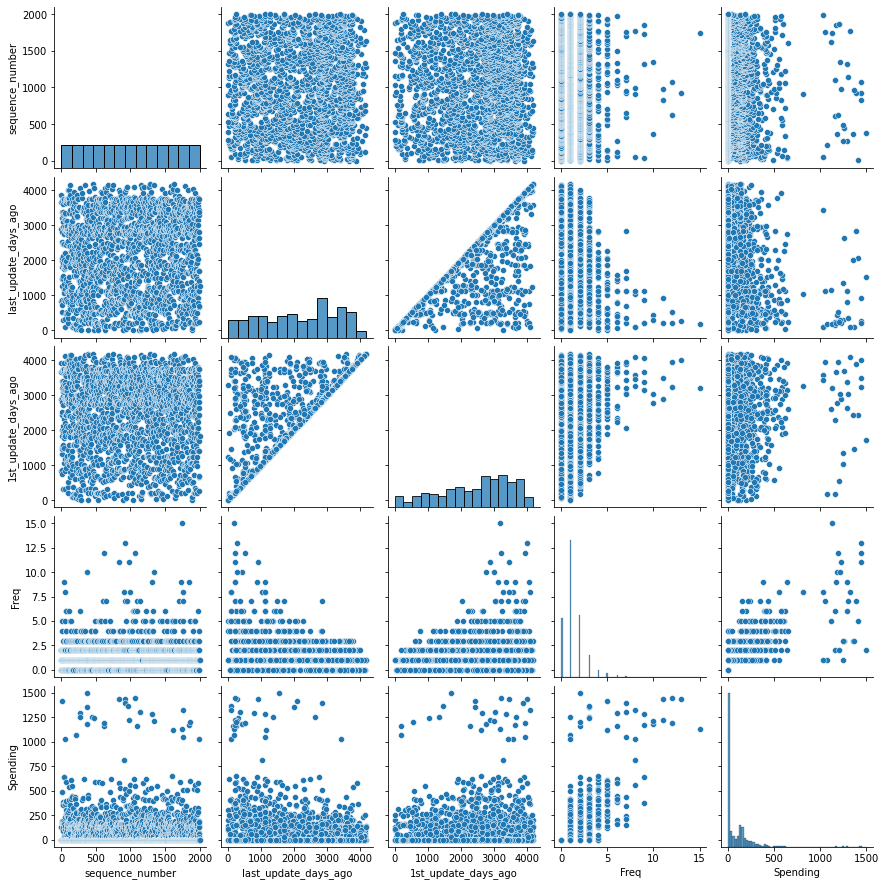

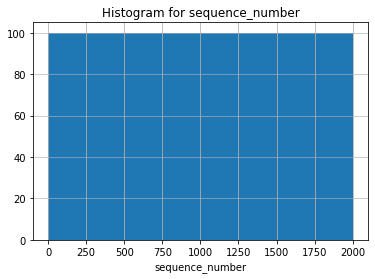

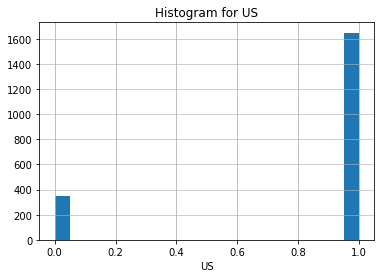

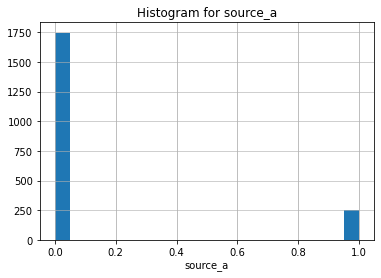

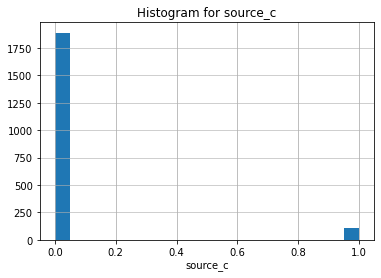

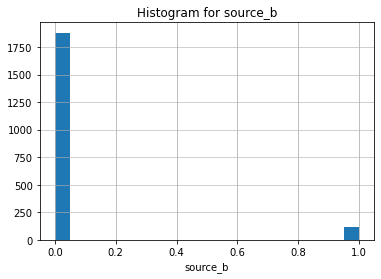

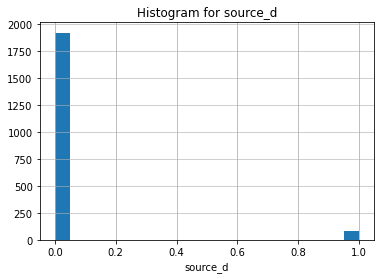

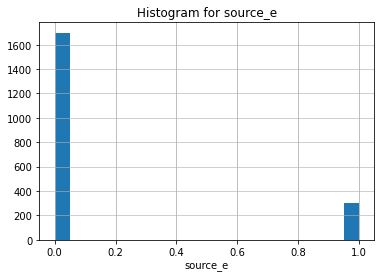

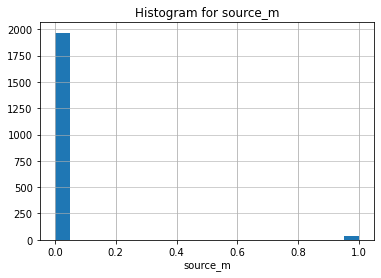

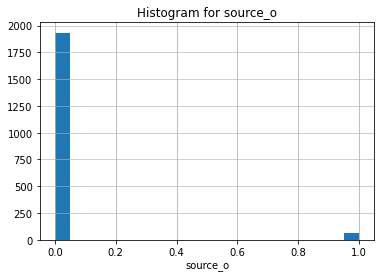

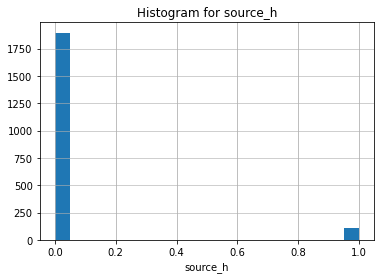

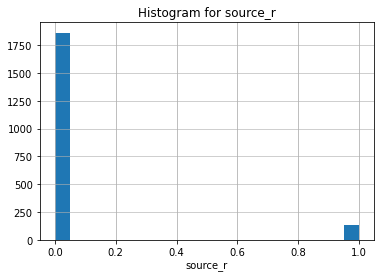

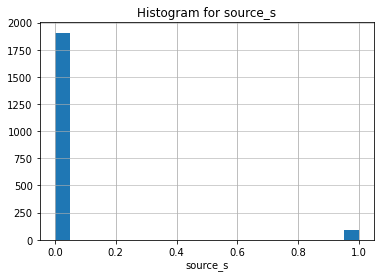

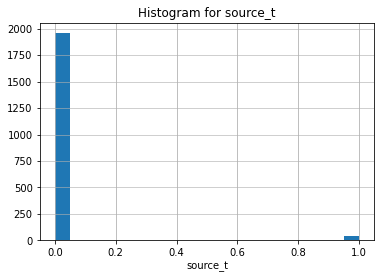

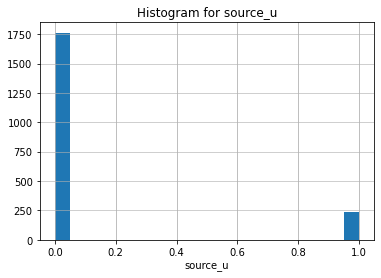

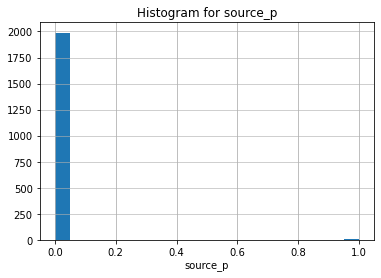

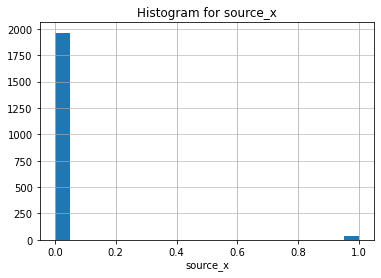

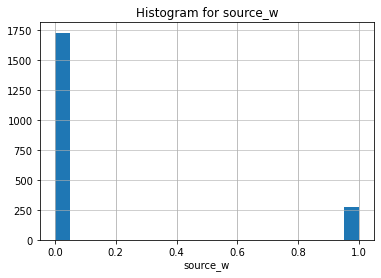

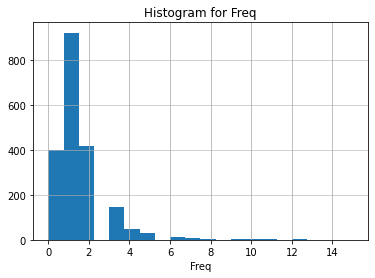

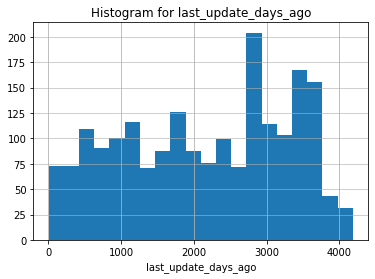

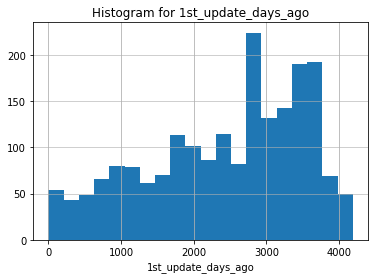

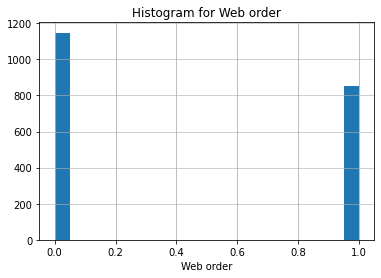

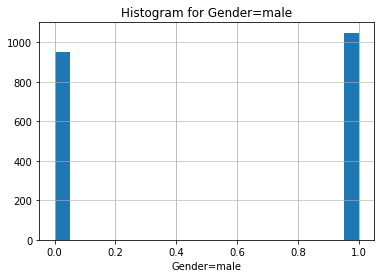

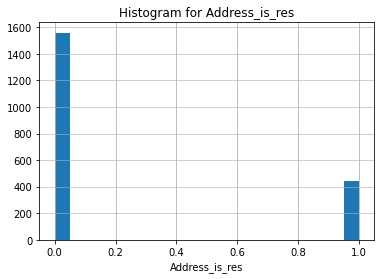

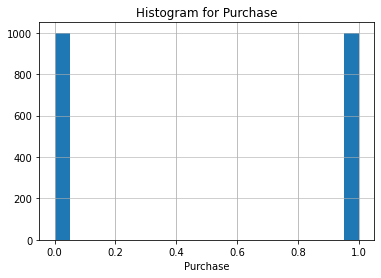

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,source_r,source_s,source_t,source_u,source_p,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
sequence_number,1.000,-0.037,-0.022,-0.021,0.032,0.032,0.007,0.031,-0.003,0.018,0.012,0.004,-0.019,-0.039,-0.037,0.006,0.009,-0.020,0.034,0.018,-0.006,0.015,0.002,-0.064,-0.046
US,-0.037,1.000,0.104,0.084,-0.033,0.096,-0.088,0.049,0.006,0.008,0.037,0.102,0.005,-0.037,-0.015,0.062,-0.205,0.033,0.038,0.076,0.004,0.027,0.021,0.022,0.003
source_a,-0.022,0.104,1.000,-0.093,-0.096,-0.079,-0.160,-0.049,-0.071,-0.090,-0.103,-0.085,-0.056,-0.140,-0.030,-0.052,-0.152,0.177,0.111,0.233,0.055,0.037,-0.021,0.212,0.184
source_c,-0.021,0.084,-0.093,1.000,-0.062,-0.051,-0.103,-0.032,-0.045,-0.057,-0.066,-0.054,-0.036,-0.090,-0.019,-0.033,-0.097,0.013,-0.168,-0.167,0.019,0.001,-0.046,-0.052,-0.039
source_b,0.032,-0.033,-0.096,-0.062,1.000,-0.053,-0.107,-0.033,-0.047,-0.059,-0.069,-0.056,-0.037,-0.093,-0.020,-0.034,-0.101,-0.066,0.249,0.249,-0.009,0.000,-0.084,-0.101,-0.059
source_d,0.032,0.096,-0.079,-0.051,-0.053,1.000,-0.088,-0.027,-0.039,-0.049,-0.056,-0.046,-0.031,-0.076,-0.016,-0.028,-0.083,0.047,0.136,0.149,-0.007,0.002,-0.050,0.028,0.003
source_e,0.007,-0.088,-0.160,-0.103,-0.107,-0.088,1.000,-0.055,-0.079,-0.099,-0.114,-0.094,-0.063,-0.155,-0.033,-0.057,-0.168,-0.048,0.074,0.052,-0.036,-0.018,-0.040,-0.047,-0.046
source_m,0.031,0.049,-0.049,-0.032,-0.033,-0.027,-0.055,1.000,-0.024,-0.030,-0.035,-0.029,-0.019,-0.048,-0.010,-0.018,-0.052,0.001,-0.019,-0.028,-0.016,0.021,-0.003,0.020,-0.009
source_o,-0.003,0.006,-0.071,-0.045,-0.047,-0.039,-0.079,-0.024,1.000,-0.044,-0.050,-0.041,-0.028,-0.068,-0.014,-0.025,-0.074,-0.122,0.186,0.226,-0.020,0.005,-0.052,-0.114,-0.070
source_h,0.018,0.008,-0.090,-0.057,-0.059,-0.049,-0.099,-0.030,-0.044,1.000,-0.064,-0.052,-0.035,-0.087,-0.018,-0.032,-0.094,0.112,-0.131,-0.169,-0.053,-0.036,0.404,-0.182,-0.103


In [ ]:
# plot pairwise for the numeric features
num_col = ['sequence_number', 'last_update_days_ago','1st_update_days_ago','Freq', 'Spending']
sns.pairplot(df[num_col], size=2.5)
plt.tight_layout
plt.show()

# plot hist for each columns
for i in features:
  dist = df[i]
  dist.hist(grid=True, bins=20)
  plt.title('Histogram for ' + str(i))
  plt.xlabel(i)
  plt.grid(axis='y', alpha=.75)
  plt.show()

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)



---


Model 1: **Linear Regression**

In [ ]:
### Fit a linear regression model ###
X = df.iloc[:,1:23]   #ignore sequance_number and Purchasing
y = df.iloc[:,24]     # grab our Spending column

slr2 = LinearRegression()
slr2.fit(X,y)

score = cross_val_score(slr2, X, y, scoring='neg_mean_squared_error', cv=10)
print("MSE: ", -(score.mean()))
print("RMSE: ", math.sqrt(-score.mean()))

print('Intercept: %.3f' % slr2.intercept_)
print('Coefficients: %.3f', slr2.coef_)

MSE:  16387.118119699895
RMSE:  128.01217957561653
Intercept: 10.653
Coefficients: %.3f [-4.93672127e+00  3.16669544e+01 -5.03394015e+01 -5.34221982e+00
 -2.31107912e+01 -5.64925448e+00 -1.33232080e+01  2.05612906e+01
 -1.01507902e+02  3.73220305e+01 -9.94076255e+00 -1.18266610e+01
  3.29968621e+01 -8.84413229e+00  3.37631673e+00  3.16051739e+00
  9.18543670e+01 -1.43217464e-02  3.05734208e-03  1.15676242e+01
 -3.03958640e+00 -6.55771040e+01]




---


Model 2: **K-nn Regression**

In [ ]:
### K-nn Regression ###
# Normalize data with min-max scaling (Z score could have been used as well)
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X)

knn = neighbors.KNeighborsRegressor()
knn.fit(X_train_scaled, y)
score_knn = cross_val_score(knn, X=X_train_scaled, y=y, scoring='neg_mean_squared_error', cv=10)

print("MSE: ", -(score_knn.mean()))
print("RMSE: ", math.sqrt(-(score_knn.mean())))

MSE:  28471.312164883995
RMSE:  168.73444273438662




---
Model 3: **Regression Tree Model**


In [ ]:
### Decision Regressor tree - Numeric Prediciton ###
regTree = DecisionTreeRegressor(random_state=42)
regTree.fit(X,y)

# cross val scores
score_regTree = cross_val_score(regTree, X, y, scoring='neg_mean_squared_error', cv=10)
print("MSE: ", -(score_regTree.mean()))
print("RMSE: ", math.sqrt(-(score_regTree.mean())))

MSE:  30157.459634261108
RMSE:  173.65903268837215


Preliminary result, Linear Regression had lowest RMSE of the three models.  Now conducting feature engineering for further comparison.

In [ ]:
### Feature Engineering ##
df_engineered = pd.read_csv(io.StringIO(uploaded['HW4_zData.csv'].decode('utf-8')))
df_engineered_X = df_engineered.iloc[:,1:23] #ignore seq_number and Purchasing
df_engineered_X['diff_update_days_ago'] = np.nan
df_engineered_X['diff_update_days_ago'] = df_engineered_X['1st_update_days_ago'] - df_engineered_X['last_update_days_ago']

df_engineered_y = df_engineered.iloc[:,24]
df_engineered_y = df_engineered_y.apply(lambda x: math.sqrt(x))

X = df_engineered_X
y = df_engineered_y

# Freq - log(x+1), 1st update_days_ago - cubic, last_update_days_ago - linear, so no transformation
# apply log(x+1)
X['Freq'] = X['Freq'].apply(lambda x: math.log(x+1))

# apply cubic
X['1st_update_days_ago'] =  X['1st_update_days_ago'].apply(lambda x: math.pow(x,3))



---


Model 1: **Linear Regression** (engineered data)

In [ ]:
### Linear Regression w/ engineered data ###
slr3 = LinearRegression()
slr3.fit(X,y)

score = cross_val_score(slr3, X, y, scoring = 'neg_mean_squared_error', cv=10)
print("MSE: ", -(score.mean()))
print("RMSE: ", math.sqrt(-(score.mean())))

print("Intercept: %.3f" % slr3.intercept_)
print("Coeffcients: ", slr3.coef_)

MSE:  27.235209079873222
RMSE:  5.218736348952036
Intercept: -1.333
Coeffcients:  [-9.60217806e-02  2.31662473e+00 -2.24965332e+00  9.59923123e-02
 -2.78159997e-01  1.43763124e-02  1.11568693e+00  1.09323734e+00
 -6.75737600e+00  1.57976550e+00 -2.88953693e-02  5.39057117e-01
  2.30313376e+00  1.65337410e+00  6.45595360e-01  9.38625831e-01
  9.68583781e+00  2.75776471e-04 -3.12860848e-11  1.11021834e+00
 -3.00253408e-01 -2.04316609e+00  1.73155077e-03]




---


Model 2: **Knn Regressor** (engineered data)

In [ ]:
### Knn w/ engineered data ###
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X)

knn2 = neighbors.KNeighborsRegressor()
knn2.fit(X_train_scaled, y)
score_knn2 = cross_val_score(knn2, X=X_train_scaled, y=y, scoring='neg_mean_squared_error', cv=10)

print("MSE: ", -(score_knn2.mean()))
print("RMSE: ", math.sqrt(-(score_knn2.mean())))


MSE:  41.38603963729595
RMSE:  6.433198243276508




---

Model 3: **Regression Tree** (engineered data)

In [ ]:
### regression tree w/ engineered data ###
regTree2 = DecisionTreeRegressor()
regTree2.fit(X,y)

score_regTree2 = cross_val_score(regTree2,X=X, y=y, scoring='neg_mean_squared_error', cv=10)
print("MSE: ", -(score_regTree2.mean()))
print("RMSE: ", math.sqrt(-(score_regTree2.mean())))

MSE:  47.17337838181054
RMSE:  6.868287878489845


Preliminary results, all models lowered the MSE as a result of the feature engineering.  Best model remains the Linear Regression with generalization performance of 27.2.  By adding engineered varaibles the model increases complexity and better fits the underlying pattern of the data.



---


Model 1: **Linear Regression Lasso** (automatic feature selection) w/ nested cross validation

In [ ]:
### Linear Regression with Lasso ###
random_state = 42

# inner and outter cross validations splits
inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

gs_lr = GridSearchCV(estimator=Lasso(random_state=42),
                     param_grid=[{'alpha' : [0, .01, .02, .05, .1, .2, .3, .4, .5, .5, .6, .8, .9, 1.0],
                                  'normalize' : ['True','False']}],
                     scoring='neg_mean_squared_error',
                     cv=inner_cv)
                    

gs_lr = gs_lr.fit(X,y)
print("\n Paramter Tuning ")
print("MSE: ", -(gs_lr.best_score_))
print("Optimal Parameter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)

nested_score_gs_lr = cross_val_score(gs_lr, X=X, y=y, cv=outer_cv,
                                     scoring='neg_mean_squared_error')
print("Nested CV MSE: ", -nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std() )

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 903, in fit
    self.normalize, default=False, estimator_name=self.__class__.__name__
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py", line 95, in _deprecate_normalize
    "Leave 'normali

ValueError: ignored



---

Model 2: **Knn Regression** (Paramter Tuning w/ Nested Cross Validation + data engineering)

In [ ]:
### Knn Paramter Tuning ###
# find max_depth that min MSE

# Inner CV
parameters = {'n_neighbors': range(1,10), 'weights':['uniform', 'distance']}
gs_knn = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=7, scoring= 'neg_mean_squared_error',
                      cv=inner_cv)
gs_knn.fit(X_train_scaled, y)
print(" Parameter Tuning \n")
print("Non-nested Performance: ", -gs_knn.best_score_)
print("Optimal Paramter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_)

# Outer CV
nested_score_gs_knn = cross_val_score(gs_knn, X=X_train_scaled, y=y, cv=outer_cv,
                                      scoring='neg_mean_squared_error')

print("nested CV Performance: ", -nested_score_gs_knn.mean(), " +/- ", nested_score_gs_knn.std())

 Parameter Tuning 

Non-nested Performance:  41.12391431966372
Optimal Paramter:  {'n_neighbors': 8, 'weights': 'uniform'}
Optimal Estimator:  KNeighborsRegressor(n_neighbors=8)
nested CV Performance:  41.85356054026381  +/-  6.99690377217339




---

Model 3: **Regressor Tree** (Paramter Tuning w/ Nested Cross Validation + data engineering)

In [ ]:
### Model 3: Regressor Tree Parameter Tuning ###
paramters = {'max_depth': range(3,20), 'min_samples_split': range(2,10)}
gs_dt =  GridSearchCV(DecisionTreeRegressor(), paramters, n_jobs=7, 
                      scoring='neg_mean_squared_error', cv=inner_cv)

gs_dt.fit(X,y)

print(" Paramter Tuning \n")
print("Non-nested Performance: ", -gs_dt.best_score_)
print("Optimal Paramter: ", gs_dt.best_params_)
print("Opitmal Estimator: ", gs_dt.best_estimator_)

#outer CV
nested_score_gs_dt = cross_val_score(gs_dt, X=X, y=y, scoring='neg_mean_squared_error', 
                                     cv=outer_cv)
print("Nested CV Performance: ", -nested_score_gs_dt.mean(), " +/- ", nested_score_gs_dt.std())

 Paramter Tuning 

Non-nested Performance:  28.699006612816003
Optimal Paramter:  {'max_depth': 5, 'min_samples_split': 9}
Opitmal Estimator:  DecisionTreeRegressor(max_depth=5, min_samples_split=9)
Nested CV Performance:  28.313492429812992  +/-  3.92089792689585


Lasso Regression Model yields best generalization performance among the three models after paramter tunning with MSE of ________.